<a href="https://colab.research.google.com/github/hiikariri/ecg-signal-processing/blob/main/final_project_dps_5023221004_Levy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Function Definition

In [50]:
def dft_by_part(start_sample, end_sample, data, replicate_coeff, sampling_freq, name):
    n_start = int(sampling_freq * start_sample)
    n_end = int(sampling_freq * end_sample)
    new_data = data[n_start:n_end]

    periodic_signal = np.tile(new_data, replicate_coeff)
    total_data_periodic = len(periodic_signal)

    plt.figure()
    plot(np.arange(0, total_data_periodic), periodic_signal,
         'Sample ' + name, 'Sequence', 'Amplitude', color='red')

    freq_periodic = np.arange(0, total_data_periodic) * sampling_freq / total_data_periodic

    dft_magnitude_periodic = dft(total_data_periodic, periodic_signal)
    return dft_magnitude_periodic, freq_periodic

def detect_peaks(data, threshold):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > threshold and data[i] > data[i-1] and data[i] > data[i+1]:
            peaks.append(i)
    return peaks

def generate_pulse_qrs(data, peaks, width=10, threshold = 20):
    pulse_qrs = np.zeros(len(data))
    # for peak in peaks:
    #     start = max(0, peak - width // 2)
    #     end = min(len(data), peak + width // 2)
    #     pulse_qrs[start:end] = 1
    pulse_qrs = data.copy()
    for i in range(len(pulse_qrs)):
      if pulse_qrs[i] >= threshold:
        pulse_qrs[i] = 1
      else:
        pulse_qrs[i] = 0
    return pulse_qrs

def plot(x_axis, data, title, xlabel, ylabel, label='Series', subplot_position=221, color='blue', stem=False, half_freq=False):
    plt.subplot(subplot_position)
    if stem:
        plt.stem(x_axis, data, label=label, linefmt=color)
        plt.xlim(0, sampling_freq/2)
    else:
        plt.plot(x_axis, data, label=label, color=color)
        if half_freq:
            plt.xlim(0, sampling_freq/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

def low_pass_filter(cutoff_freq, indices, sampling_freq, data):
    ohm = 2 * np.pi * cutoff_freq / sampling_freq
    h = np.zeros(len(indices))
    y = np.zeros(len(data))

    for i in range(len(indices)):
        if indices[i] == 0:
            h[i] = ohm / np.pi
        else:
            h[i] = np.sin(ohm * indices[i]) / (np.pi * indices[i])

    for n in range(len(data)):
        for i in range(len(indices)):
            if n - i >= 0:
                y[n] += h[i] * data[n - i]
    y = np.convolve(data, h, mode="same")
    return y

def band_pass_filter(low_cutoff_freq, high_cutoff_freq, indices, sampling_freq, data):
    low_cutoff_ohm = 2 * np.pi * low_cutoff_freq / sampling_freq
    high_cutoff_ohm = 2 * np.pi * high_cutoff_freq / sampling_freq
    h = np.zeros(len(indices))
    y = np.zeros(len(data))

    for i in range(len(indices)):
        if indices[i] == 0:
            h[i] = (high_cutoff_ohm - low_cutoff_ohm) / np.pi
        else:
            h[i] = (np.sin(high_cutoff_ohm * indices[i]) - np.sin(low_cutoff_ohm * indices[i])) / (np.pi * indices[i])

    for n in range(len(data)):
        for i in range(len(indices)):
            if n - i >= 0:
                y[n] += h[i] * data[n - i]

    y = np.convolve(data, h, mode='same')

    return y

def filter(data, sampling_freq, cutoff_freq=0, filter_order=1, low_cutoff_freq=0, high_cutoff_freq=0, filter_type="low_pass"):
    M = (filter_order - 1) // 2
    indices = np.arange(-M, M + 1, 1, dtype=int)

    if filter_type == "low_pass":
        filtered_signal = low_pass_filter(cutoff_freq, indices, sampling_freq, data)
    elif filter_type == "high_pass":
        raise NotImplementedError("High-pass filter is not implemented.")
    elif filter_type == "band_pass":
        filtered_signal = band_pass_filter(low_cutoff_freq, high_cutoff_freq, indices, sampling_freq, data)
    elif filter_type == "band_stop":
        raise NotImplementedError("Band-stop filter is not implemented.")
    else:
        raise ValueError("Invalid filter type")

    return filtered_signal

def spline_interpolate(x_source, y_source):
    spline = make_interp_spline(x_source, y_source, k=3)
    x_smooth = np.linspace(x_source.min(), x_source.max(), 300)
    y_smooth = spline(x_smooth)

    return x_smooth, y_smooth


def dft(total_data, data):
    x_real = np.zeros(total_data)
    x_im = np.zeros(total_data)
    dft_magnitude = np.zeros(total_data)

    for k in range(total_data):
        for n in range(total_data):
            x_real[k] += data[n] * np.cos(2 * np.pi * k * n / total_data)
            x_im[k] -= data[n] * np.sin(2 * np.pi * k * n / total_data)

    for k in range(total_data):
        dft_magnitude[k] = np.sqrt(x_real[k]**2 + x_im[k]**2)

    return dft_magnitude

def moving_average(data, orde_filter):
    y = np.zeros(len(data))
    for i in range(len(data)):
        for j in range(orde_filter):
            if i - j >= 0:
                y[i] += data[i - j]
        y[i] /= orde_filter
    return y

# Signal Input

Mounted at /content/drive
Enter the filter order: 3
Enter the path of the data: Data ECG Levy
Enter the sampling frequency: 125
Loading data...


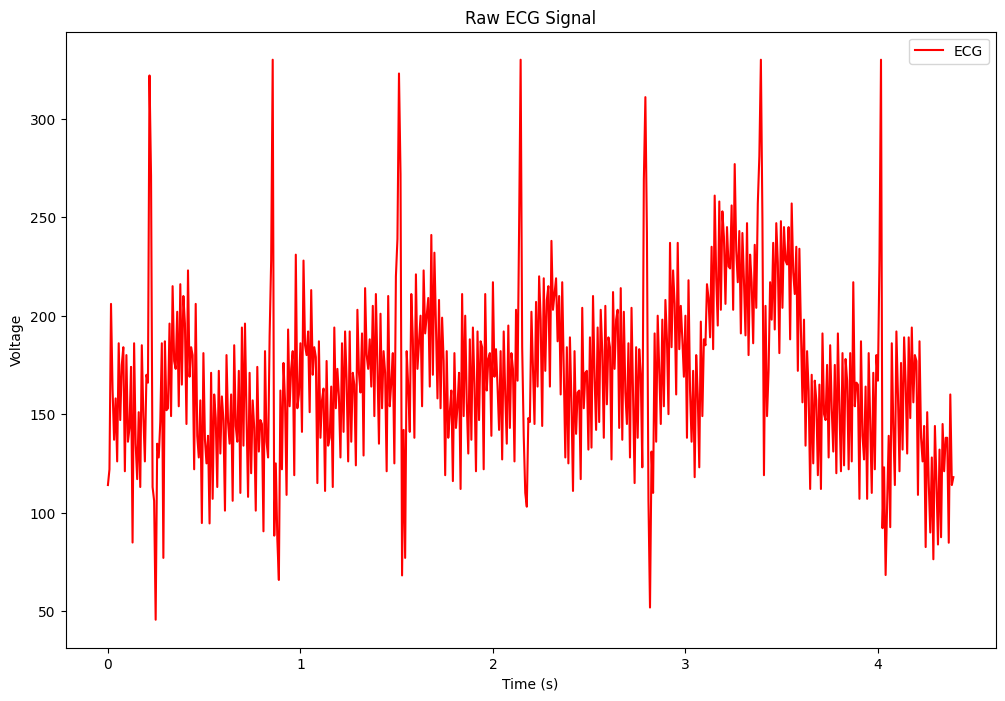

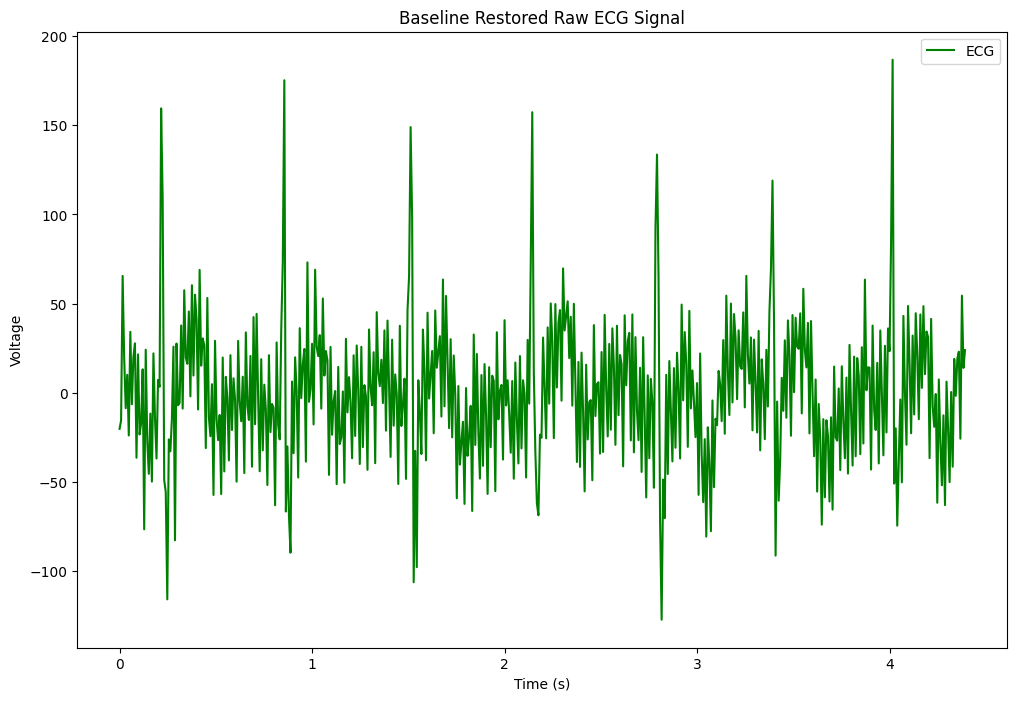

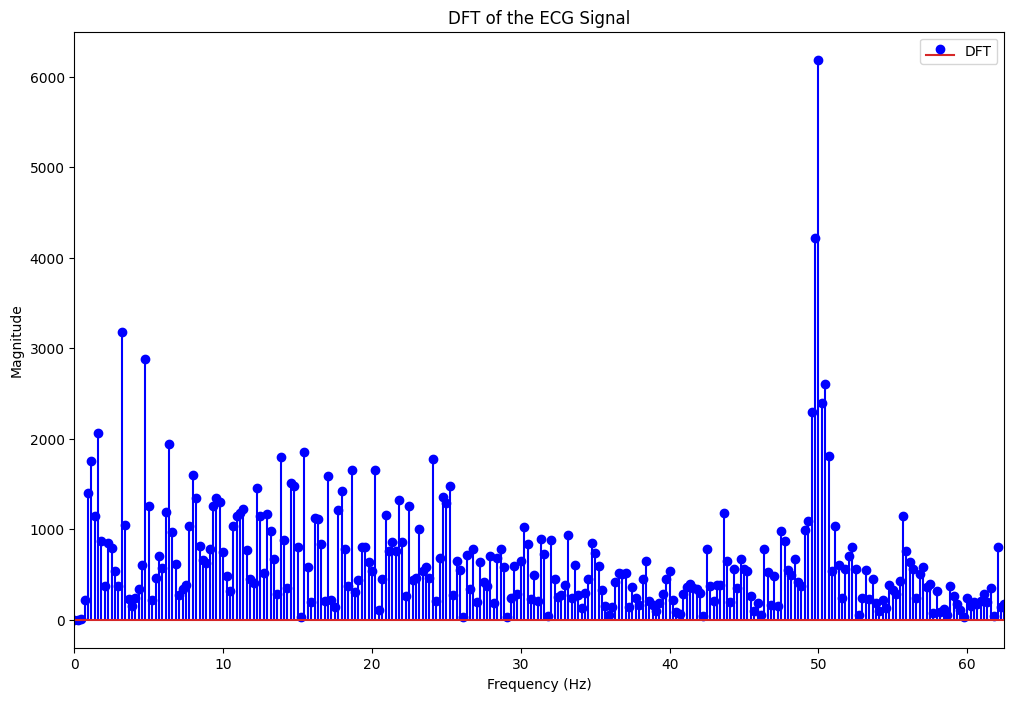

In [51]:
drive.mount('/content/drive', force_remount = True)
orde = int(input("Enter the filter order: "))
path = input("Enter the path of the data: ")
sampling_freq = int(input("Enter the sampling frequency: "))
try:
    print("Loading data...")
    data_path = "/content/drive/MyDrive/" + path + ".txt"
    sequence, data = np.loadtxt(data_path, skiprows=1, delimiter=None, unpack=True)
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

total_data = len(data)
sampling_time = total_data / sampling_freq
time_axis = np.arange(0, sampling_time, 1/sampling_freq)
freq_axis = np.arange(0, total_data) * sampling_freq / total_data

plt.figure(figsize=(12, 8))
plot(time_axis, data, 'Raw ECG Signal', 'Time (s)', 'Voltage', 'ECG', 111, color='red')

x = np.arange(len(data))
p = np.polyfit(x, data, 10)
trend = np.polyval(p, x)
data = data - trend
# data = data - np.mean(data)
plt.figure(figsize=(12, 8))
plot(time_axis, data, 'Baseline Restored Raw ECG Signal', 'Time (s)', 'Voltage', 'ECG', 111, color='green')

dft_magnitude = dft(total_data, data)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude, 'DFT of the ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

# Filter Processing

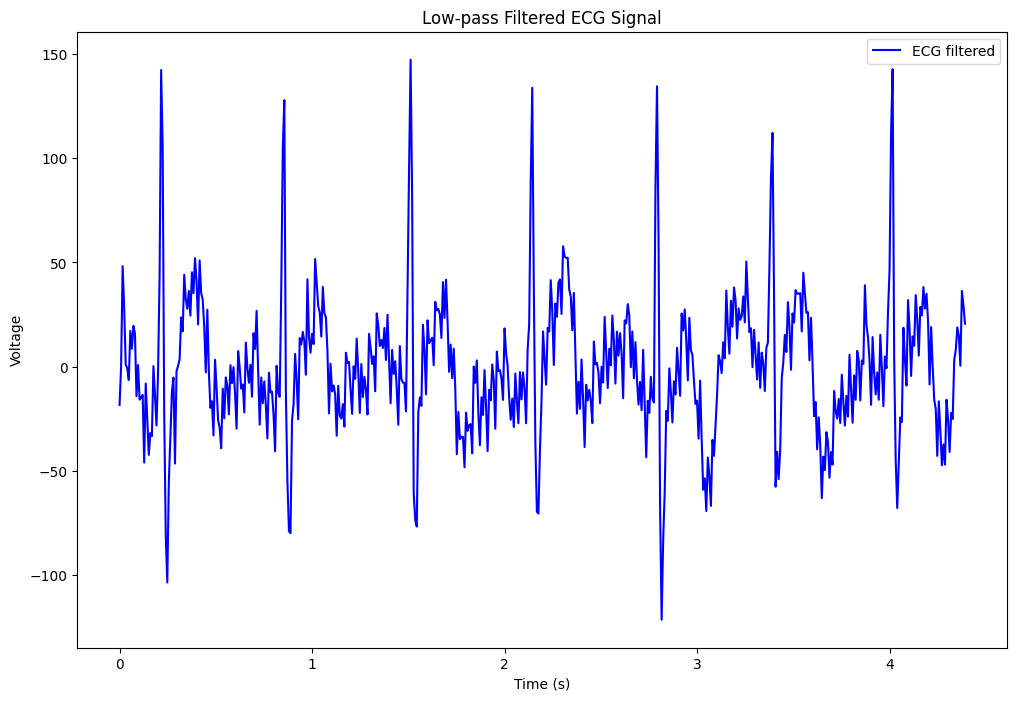

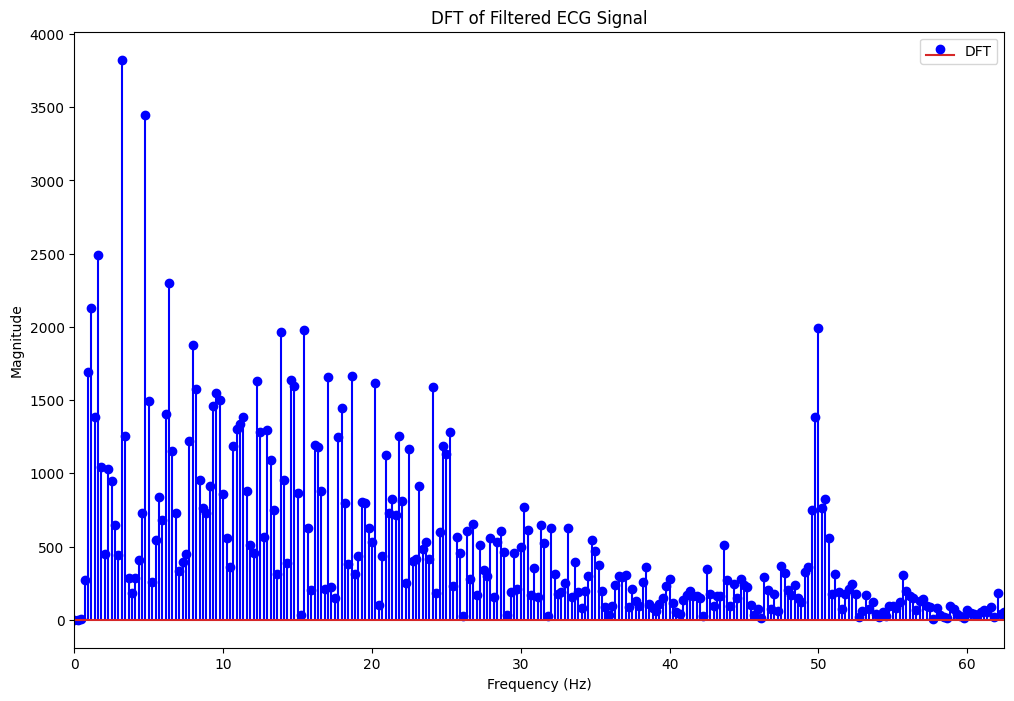

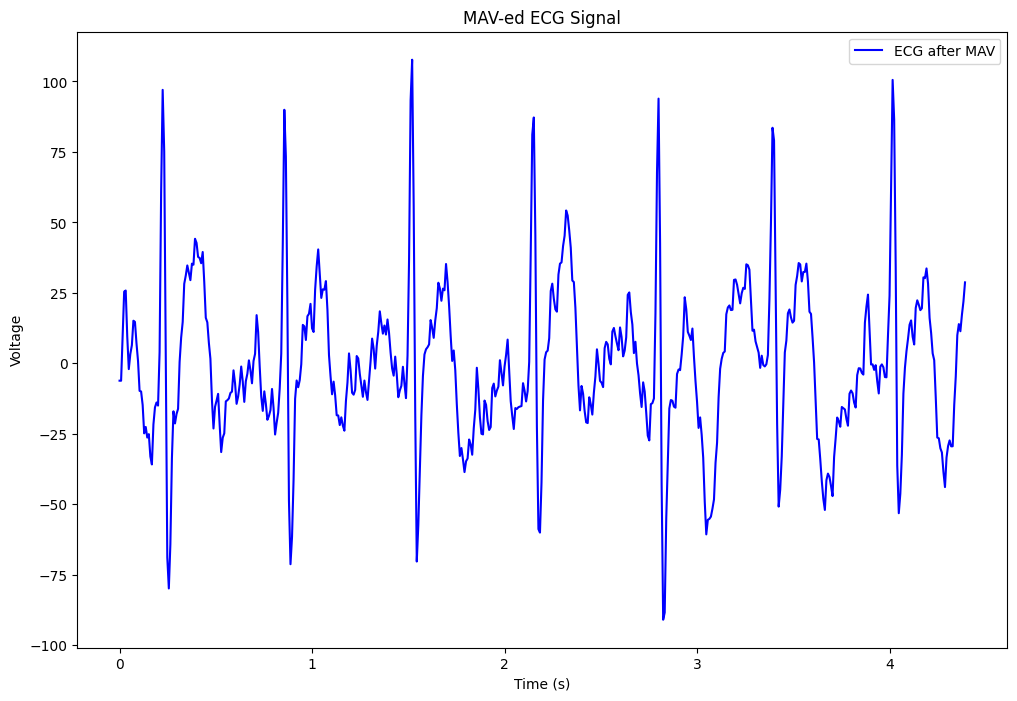

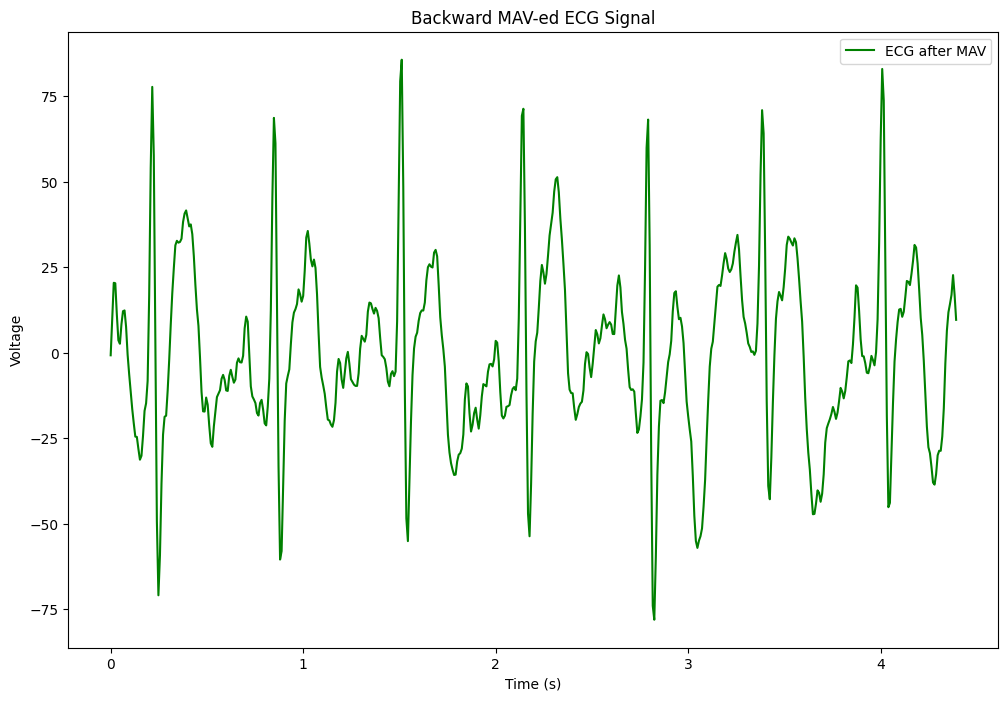

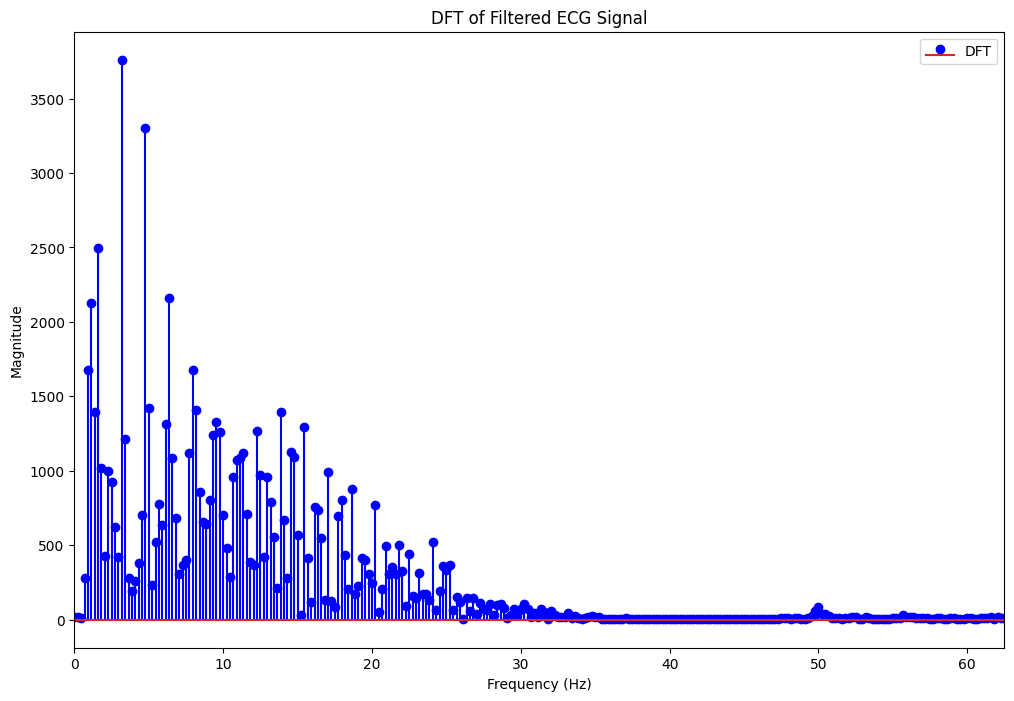

In [52]:
data_filtered = filter(data=data, cutoff_freq=45, filter_order=orde, sampling_freq=125)
plt.figure(figsize=(12, 8))
plot(time_axis, data_filtered, 'Low-pass Filtered ECG Signal', 'Time (s)', 'Voltage', 'ECG filtered', 111, color='blue')

dft_magnitude_filtered = dft(total_data, data_filtered)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_filtered, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

# data_filtered = filter(data=data_filtered[::-1], cutoff_freq=50, filter_order=orde, sampling_freq=125)[::-1]
# plt.figure(figsize=(12, 8))
# plot(time_axis, data_filtered, 'Low-pass Filtered ECG Signal Backward', 'Time (s)', 'Voltage', 'ECG filtered backward', 111, color='green')

# dft_magnitude_filtered = dft(total_data, data_filtered)
# plt.figure(figsize=(12, 8))
# plot(freq_axis, dft_magnitude_filtered, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

data_filtered = moving_average(data_filtered, 3)
plt.figure(figsize=(12, 8))
plot(time_axis, data_filtered, 'MAV-ed ECG Signal', 'Time (s)', 'Voltage', 'ECG after MAV', 111, color='blue')

data_filtered = moving_average(data_filtered[::-1], 3)[::-1]
fig, ax = plt.subplots(figsize=(12, 8))
plot(time_axis, data_filtered, 'Backward MAV-ed ECG Signal', 'Time (s)', 'Voltage', 'ECG after MAV', 111, color='green')

dft_magnitude_filtered = dft(total_data, data_filtered)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_filtered, 'DFT of Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

# DFT by Part

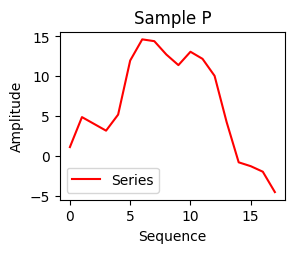

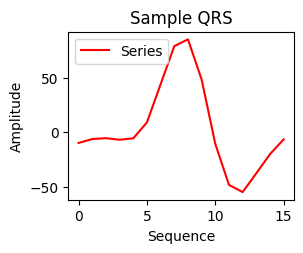

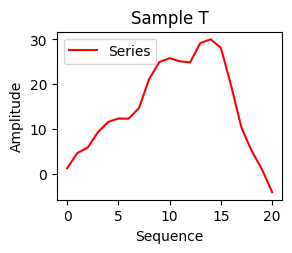

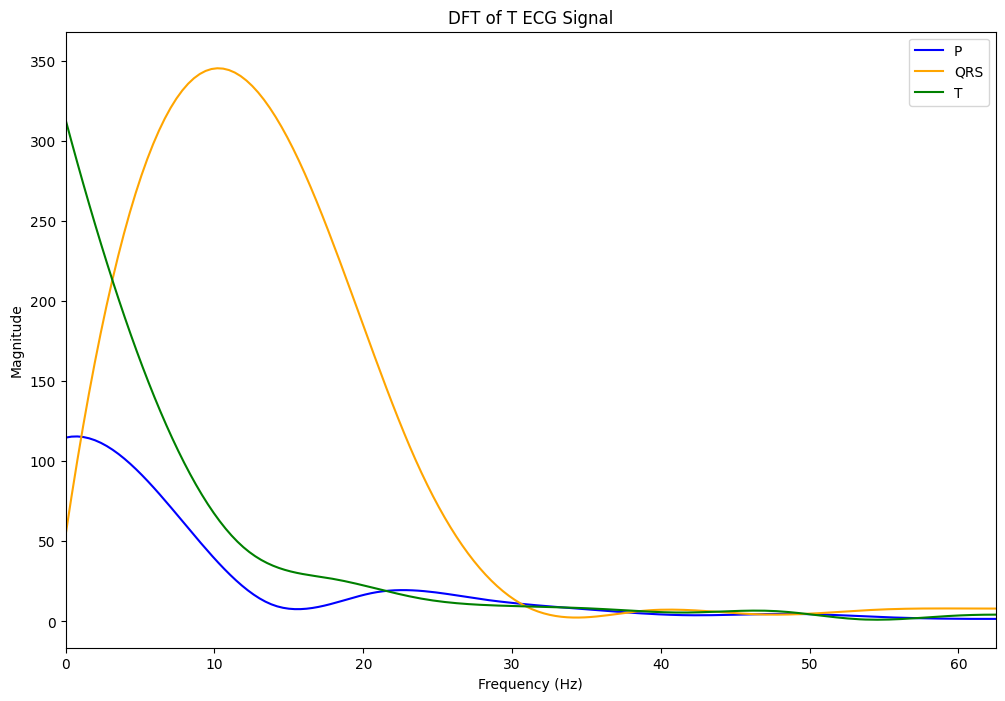

In [53]:
p_wave, p_wave_freq = dft_by_part(1.3, 1.44, data_filtered, 1, sampling_freq, 'P')
qrs_wave, qrs_wave_freq = dft_by_part(1.45, 1.58, data_filtered, 1, sampling_freq, 'QRS')
t_wave, t_wave_freq = dft_by_part(1.58, 1.75, data_filtered, 1, sampling_freq, 'T')

p_wave_freq_smooth, p_wave_smooth = spline_interpolate(p_wave_freq, p_wave)
qrs_wave_freq_smooth, qrs_wave_smooth = spline_interpolate(qrs_wave_freq, qrs_wave)
t_wave_freq_smooth, t_wave_smooth = spline_interpolate(t_wave_freq, t_wave)

plt.figure(figsize=(12, 8))
plot(p_wave_freq_smooth, p_wave_smooth, 'DFT of P ECG Signal', 'Frequency (Hz)', 'Magnitude', 'P', 111, stem=False, half_freq=True)
plot(qrs_wave_freq_smooth, qrs_wave_smooth, 'DFT of QRS ECG Signal', 'Frequency (Hz)', 'Magnitude', 'QRS', 111, color='orange', stem=False, half_freq=True)
plot(t_wave_freq_smooth, t_wave_smooth, 'DFT of T ECG Signal', 'Frequency (Hz)', 'Magnitude', 'T', 111, color='green', stem=False, half_freq=True)

# QRS and R-R Detection

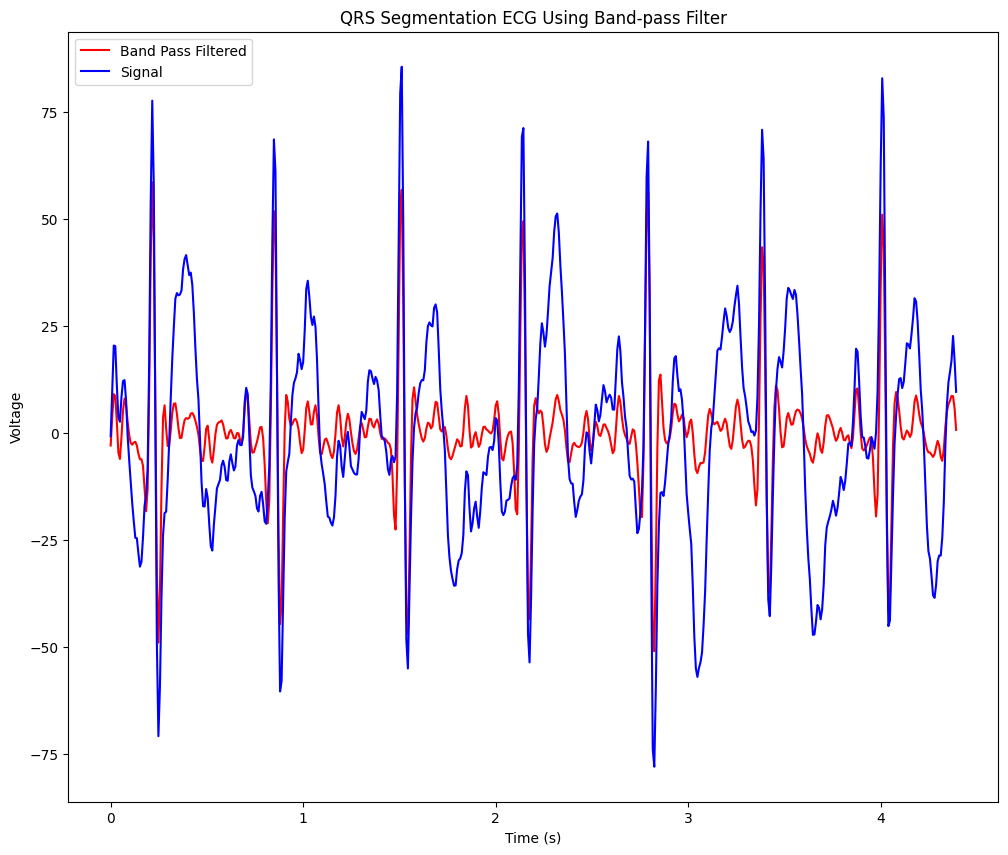

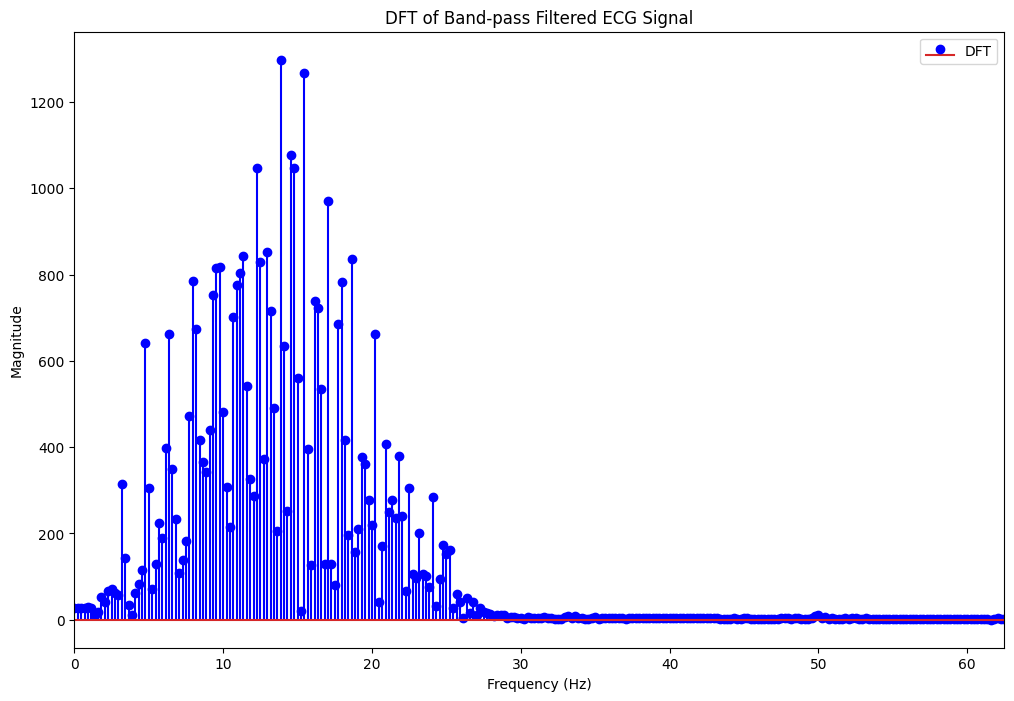

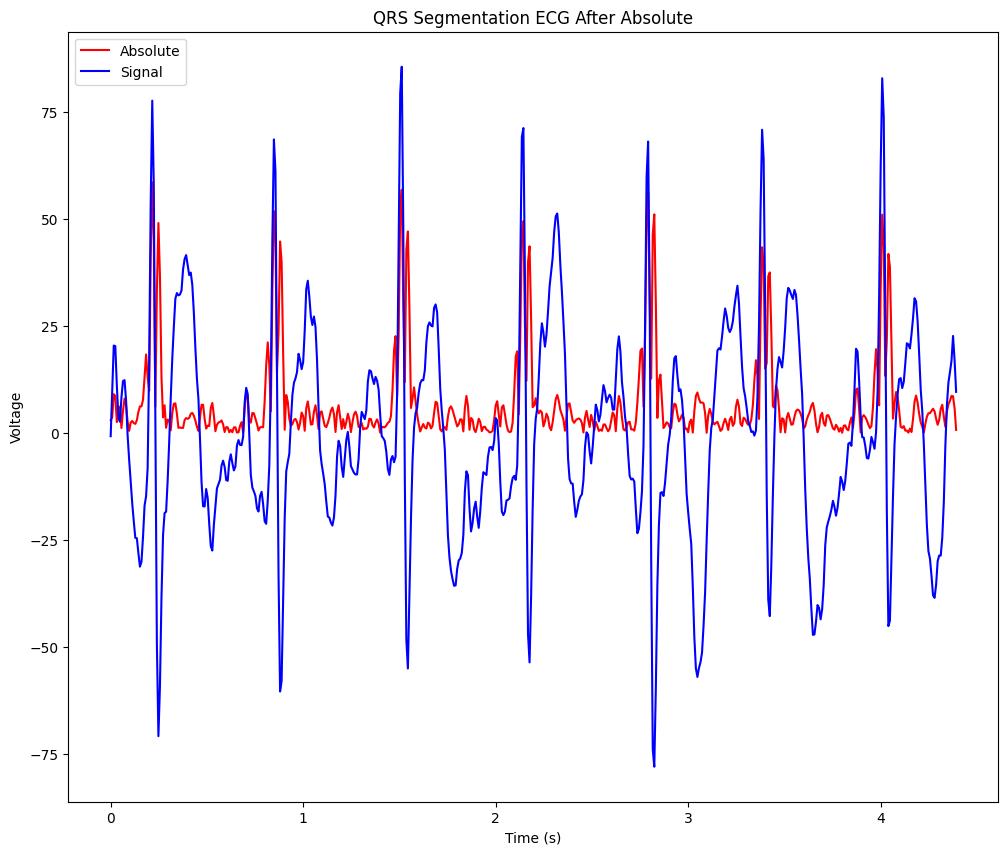

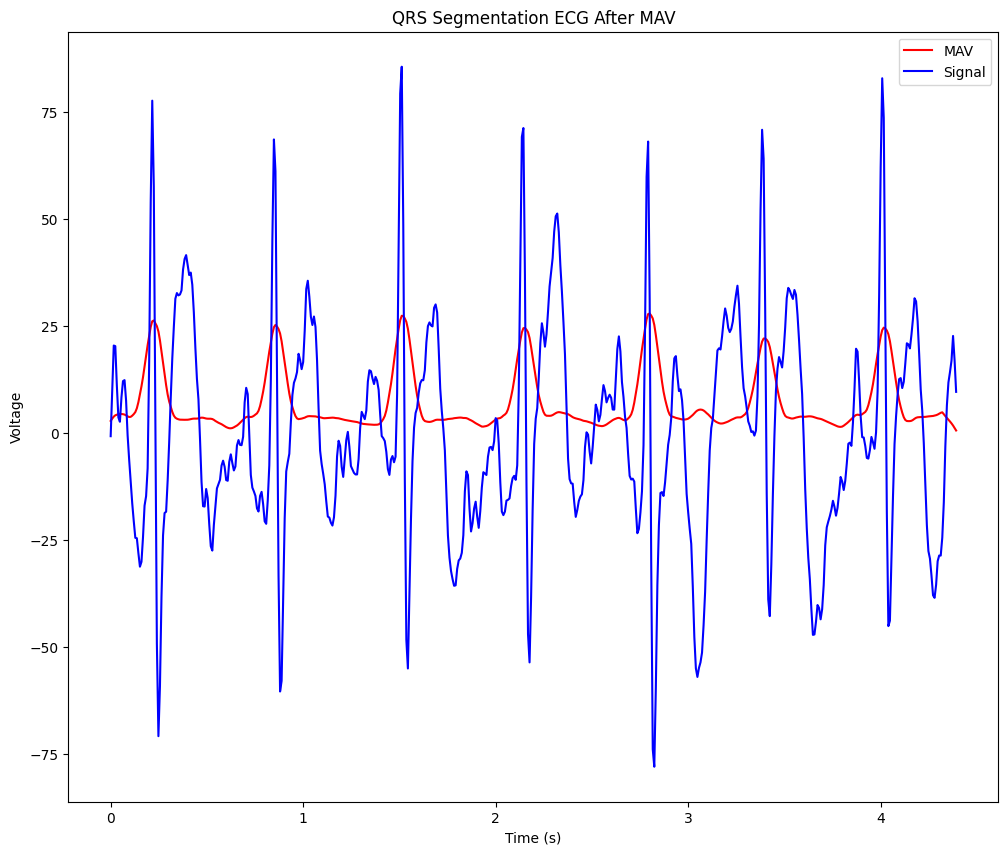

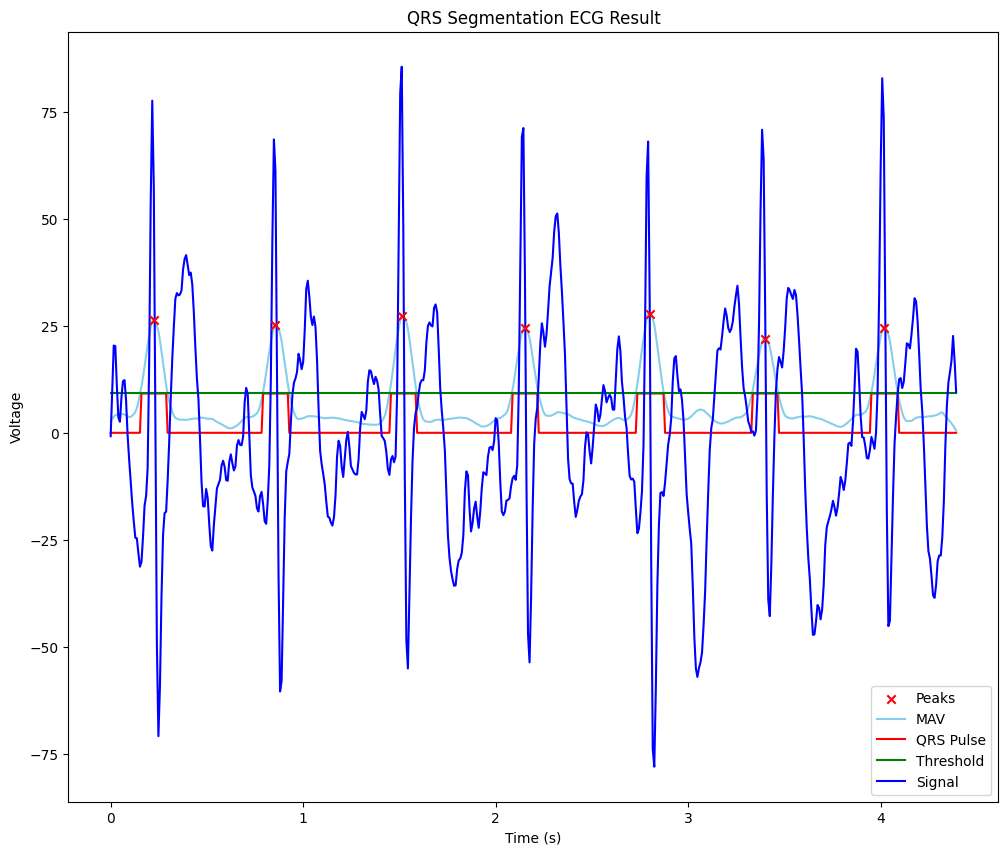

In [54]:
segmented_data = filter(data=data_filtered, filter_order=9, sampling_freq=125, filter_type="band_pass", low_cutoff_freq=8, high_cutoff_freq=23)
# segmented_data = filter(data=data_filtered[::-1], filter_order=9, sampling_freq=125, filter_type="band_pass", low_cutoff_freq=8, high_cutoff_freq=23)[::-1]
plt.figure(figsize=(12, 10))
plot(time_axis, segmented_data, 'QRS Segmentation ECG Using Band-pass Filter', 'Time (s)', 'Voltage', 'Band Pass Filtered', 111, color='red')
plot(time_axis, data_filtered, 'QRS Segmentation ECG Using Band-pass Filter', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

dft_magnitude_segmented = dft(total_data, segmented_data)
plt.figure(figsize=(12, 8))
plot(freq_axis, dft_magnitude_segmented, 'DFT of Band-pass Filtered ECG Signal', 'Frequency (Hz)', 'Magnitude', 'DFT', 111, stem=True)

segmented_data = abs(segmented_data)
plt.figure(figsize=(12, 10))
plot(time_axis, segmented_data, 'QRS Segmentation ECG After Absolute', 'Time (s)', 'Voltage', 'Absolute', 111, color='red')
plot(time_axis, data_filtered, 'QRS Segmentation ECG After Absolute', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

segmented_data = moving_average(segmented_data, 10)
segmented_data = moving_average(segmented_data[::-1], 10)[::-1]
plt.figure(figsize=(12, 10))
plot(time_axis, segmented_data, 'QRS Segmentation ECG After MAV', 'Time (s)', 'Voltage', 'MAV', 111, color='red')
plot(time_axis, data_filtered, 'QRS Segmentation ECG After MAV', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

threshold = 0.33 * np.max(segmented_data)
peaks = detect_peaks(segmented_data, threshold)
pulse_qrs = generate_pulse_qrs(segmented_data, peaks, width=10, threshold=threshold)
pulse_qrs = pulse_qrs * threshold

threshold_axis = [threshold] * total_data
peak_times = time_axis[peaks]
peak_values = segmented_data[peaks]
plt.figure(figsize=(12, 10))
plt.scatter(peak_times, peak_values, color='red', zorder=5, label='Peaks', marker='x')
plot(time_axis, segmented_data, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'MAV', 111, color='skyblue')
plot(time_axis, pulse_qrs, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'QRS Pulse', 111, color='red')
plot(time_axis, threshold_axis, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'Threshold', 111, color='green')
plot(time_axis, data_filtered, 'QRS Segmentation ECG Result', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

# Signal Analysis Result

In [55]:
times_of_rising_edges = []
for i in range(len(pulse_qrs)):
  if pulse_qrs[i] > pulse_qrs[i - 1]:
      times_of_rising_edges.append(time_axis[i])

filtered_times_of_rising_edges = [times_of_rising_edges[0]]
for i in range(len(times_of_rising_edges)):
  if (times_of_rising_edges[i] - filtered_times_of_rising_edges[-1]) >= 0.5:
      filtered_times_of_rising_edges.append(times_of_rising_edges[i])

rr_interval = []
for i in range(len(filtered_times_of_rising_edges)):
  if (i == len(filtered_times_of_rising_edges) - 1): break
  rr_interval.append(filtered_times_of_rising_edges[i+1] - filtered_times_of_rising_edges[i])

rr_peak_interval = []
for i in range(len(peak_times)):
  if (i == len(peak_times) - 1): break
  rr_peak_interval.append(peak_times[i+1] - peak_times[i])

print(filtered_times_of_rising_edges)
print(rr_interval)
print(rr_peak_interval)
rr_mean = np.mean(rr_interval)
heart_rate = 60.0 / rr_mean
rr_peak_mean = np.mean(rr_peak_interval)
heart_rate_2 = 60.0 / rr_peak_mean
print("Subject Heart Rate is " + str(heart_rate) + " BPM")
print("Subject Heart Rate is " + str(heart_rate_2) + " BPM")

[0.16, 0.792, 1.456, 2.088, 2.736, 3.336, 3.952]
[0.632, 0.6639999999999999, 0.6320000000000001, 0.6480000000000001, 0.5999999999999996, 0.6160000000000001]
[0.632, 0.656, 0.6400000000000001, 0.6480000000000001, 0.5999999999999996, 0.6160000000000001]
Subject Heart Rate is 94.9367088607595 BPM
Subject Heart Rate is 94.9367088607595 BPM


# P and T Segmentation

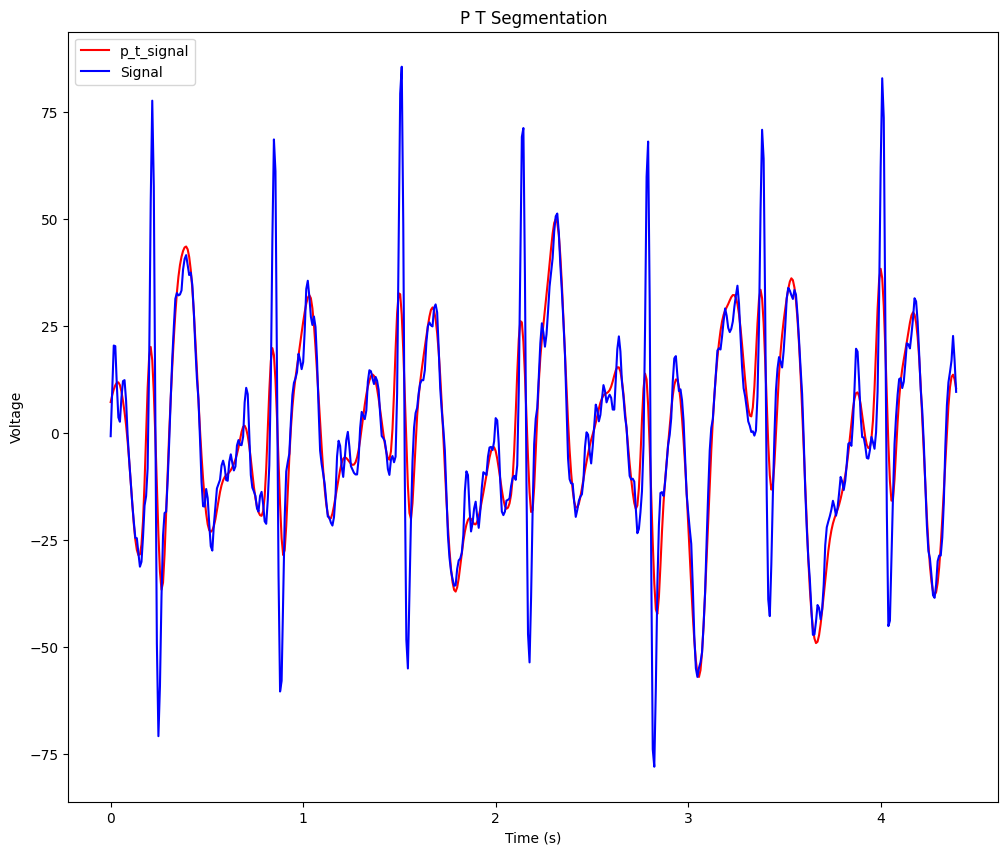

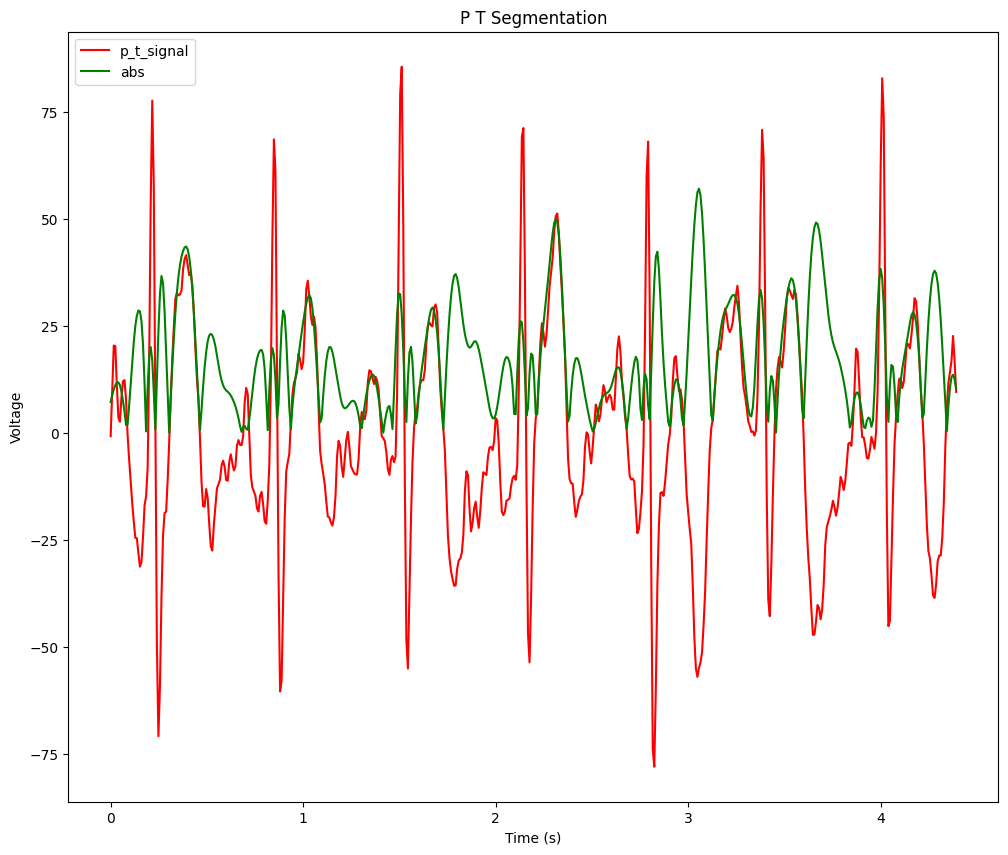

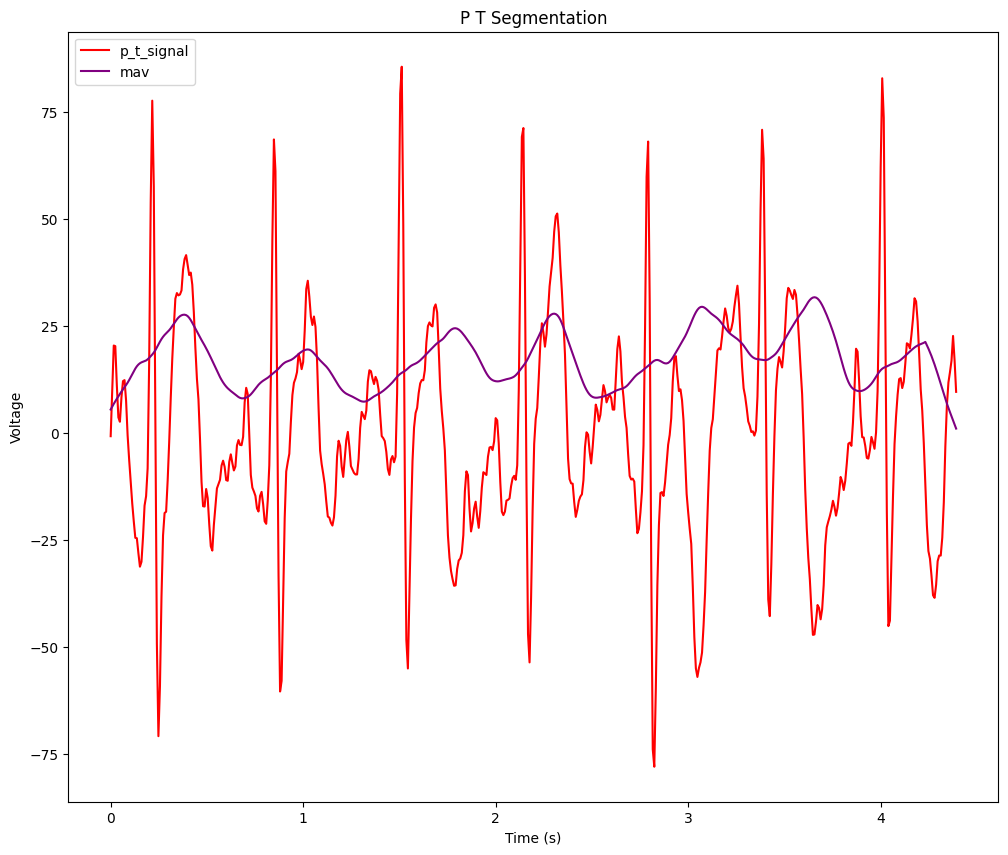

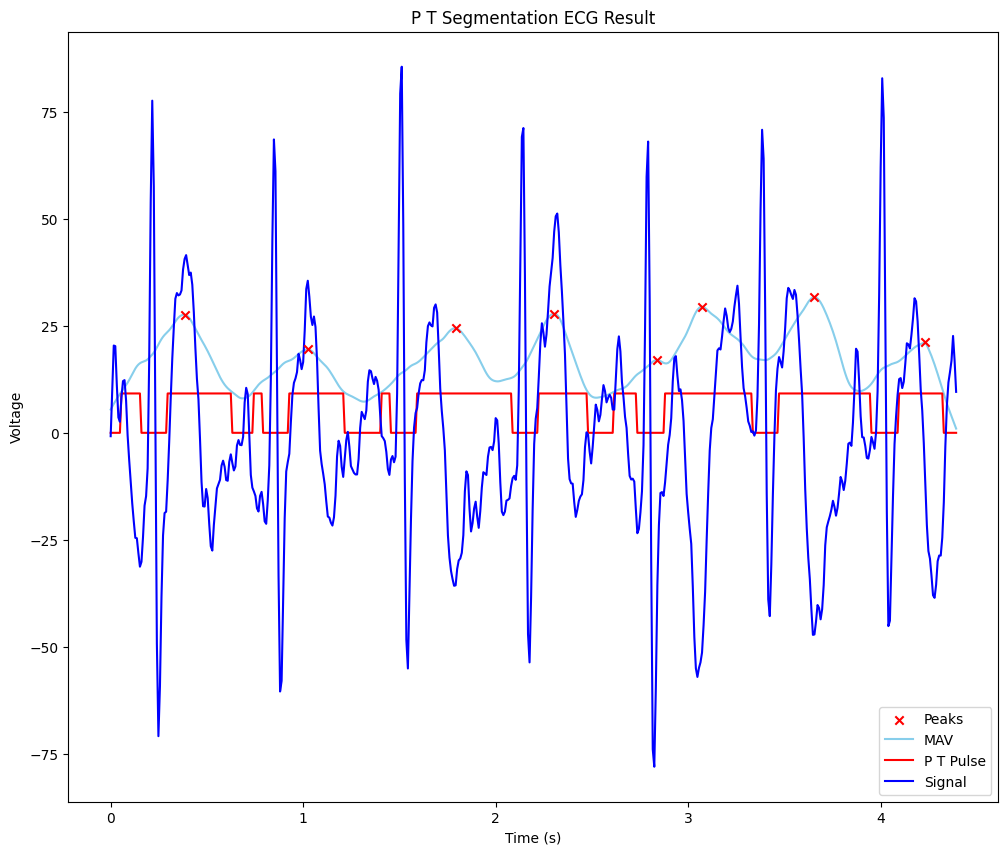

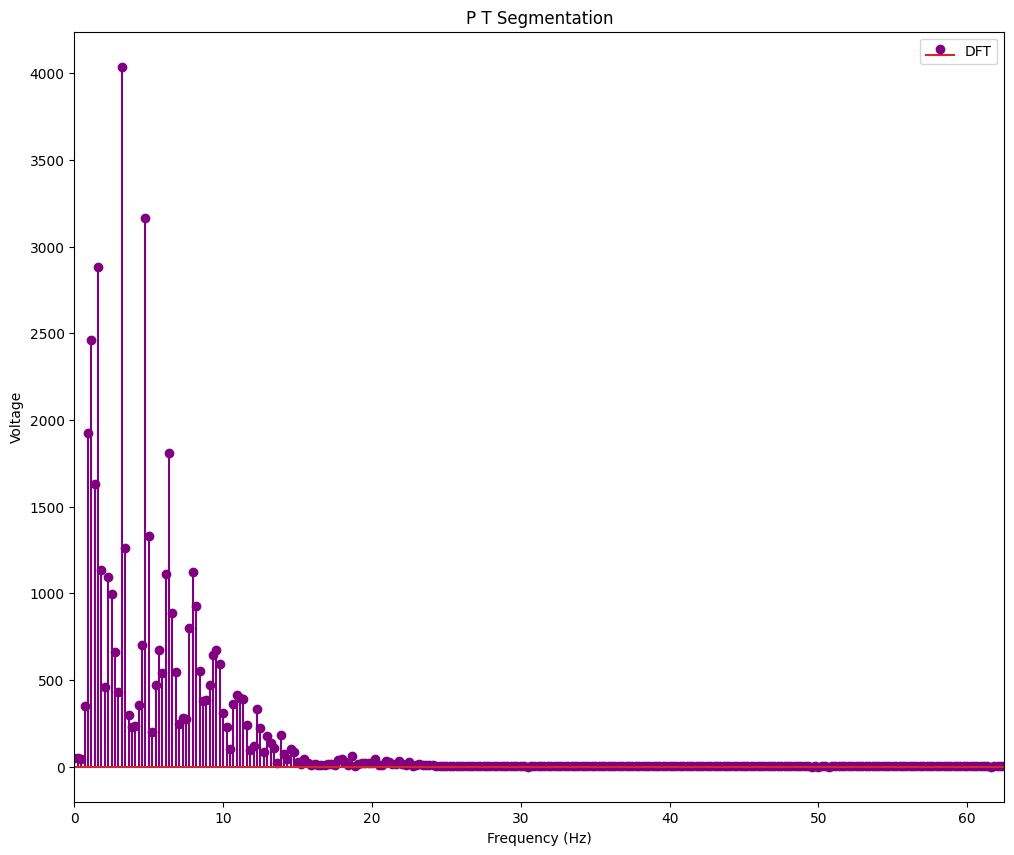

In [56]:
new_data_filtered = data_filtered.copy()
new_data_filtered = filter(new_data_filtered, sampling_freq, cutoff_freq=10, filter_order=11, filter_type="low_pass")
plt.figure(figsize=(12, 10))
plot(time_axis, new_data_filtered, 'P T Segmentation', 'Time (s)', 'Voltage', 'p_t_signal', 111, color='red')
plot(time_axis, data_filtered, 'P T Segmentation', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')

dft_new = dft(len(new_data_filtered), new_data_filtered)
abs_t = abs(new_data_filtered)
mav_t = moving_average(abs_t, 21)
mav_t = moving_average(mav_t[::-1], 21)[::-1]

threshold_new = 0.3 * np.max(mav_t)
peaks_new = detect_peaks(mav_t, threshold_new)
pulse_t = generate_pulse_qrs(mav_t, peaks_new, width=10, threshold=threshold_new)
pulse_t = pulse_t * threshold
pulse_t = pulse_t - pulse_qrs




peak_times_new = time_axis[peaks_new]
peak_values_new = mav_t[peaks_new]


plt.figure(figsize=(12, 10))
plot(time_axis, data_filtered, 'P T Segmentation', 'Time (s)', 'Voltage', 'p_t_signal', 111, color='red')
plot(time_axis, abs_t, 'P T Segmentation', 'Time (s)', 'Voltage', 'abs', 111, color='green')
plt.figure(figsize=(12, 10))
plot(time_axis, data_filtered, 'P T Segmentation', 'Time (s)', 'Voltage', 'p_t_signal', 111, color='red')
plot(time_axis, mav_t, 'P T Segmentation', 'Time (s)', 'Voltage', 'mav', 111, color='purple')
plt.figure(figsize=(12, 10))
plt.scatter(peak_times_new, peak_values_new, color='red', zorder=5, label='Peaks', marker='x')
plot(time_axis, mav_t, 'P T Segmentation ECG Result', 'Time (s)', 'Voltage', 'MAV', 111, color='skyblue')
plot(time_axis, pulse_t, 'P T Segmentation ECG Result', 'Time (s)', 'Voltage', 'P T Pulse', 111, color='red')
plot(time_axis, data_filtered, 'P T Segmentation ECG Result', 'Time (s)', 'Voltage', 'Signal', 111, color='blue')
plt.figure(figsize=(12, 10))
plot(freq_axis, dft_new, 'P T Segmentation', 'Frequency (Hz)', 'Voltage', 'DFT', 111, color='purple', stem=True)